***Installing required libraries***

In [1]:
# Run this once at top of notebook
!pip install -q lightgbm shap

In [2]:
# standard imports
import pandas as pd, numpy as np, math, joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


***Uploading CSV file***

In [3]:
# Read CSV - try to parse Date with multiple formats
df = pd.read_csv('/content/Amazon Sale Report.csv')
# If Date is like '04-30-22' parse with dayfirst=False and two-digit year
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=False)
print("Rows, cols:", df.shape)
df.head(3)

Rows, cols: (24151, 24)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


***Feature Selection***

In [53]:
# Columns we will use
cols_needed = ['Date','SKU','Category','Qty','Amount']
# Some uploaded files have extra spaces in names; normalize:
df.columns = [c.strip() for c in df.columns]

# Keep and clean
data = df[cols_needed].copy()
data['Qty'] = pd.to_numeric(data['Qty'], errors='coerce').fillna(0).astype(int)
data['Amount'] = pd.to_numeric(data['Amount'], errors='coerce').fillna(0.0)
data = data.dropna(subset=['Date','SKU'])
print("Prepared data rows:", data.shape[0])
data.sample(5)


Prepared data rows: 24151


,Date,SKU,Category,Qty,Amount
19587,2022-04-19,JNE3421-KR-N-XXL,kurta,1,399.0
19934,2022-04-18,JNE3440-KR-N-XXL,kurta,1,399.0
11332,2022-04-23,J0301-TP-XXXL,Top,1,463.0
9572,2022-04-24,JNE3652-TP-N-M,Top,1,339.0
22185,2022-04-17,SET277-KR-NP-XXL,Set,1,1338.0


***Aggregate to daily SKU-level demand***

In [6]:
# Aggregate quantity sold per SKU per day
daily = data.groupby(['SKU','Date']).agg({
    'Qty':'sum',
    'Amount':'sum',
    'Category': lambda x: x.mode().iloc[0] if len(x.mode())>0 else x.iloc[0]
}).reset_index().rename(columns={'Qty':'demand','Amount':'revenue'})
daily.head()


,SKU,Date,demand,revenue,Category
0,AN202-ORANGE-XXL,2022-04-20,1,229.0,Bottom
1,AN208-MUSTARD-XXL,2022-04-24,1,229.0,Bottom
2,BL001-50PINK,2022-04-30,1,419.0,Blouse
3,BL003-50BLACK,2022-04-17,1,419.0,Blouse
4,BL003-50BLACK,2022-04-27,0,0.0,Blouse


***Ensure complete date range per SKU (fill zeros)***

In [8]:
all_skus = daily['SKU'].unique()
min_date, max_date = daily['Date'].min(), daily['Date'].max()
full_index = pd.MultiIndex.from_product([all_skus, pd.date_range(min_date, max_date)], names=['SKU','Date'])
daily = daily.set_index(['SKU','Date']).reindex(full_index).reset_index()
daily['demand'] = daily['demand'].fillna(0)
daily['revenue'] = daily['revenue'].fillna(0)
daily['Category'] = daily['Category'].fillna('Unknown')
daily.head()


,SKU,Date,demand,revenue,Category
0,BL021-71BLACK,2022-04-16,0.0,0.0,Blouse
1,BL021-71BLACK,2022-04-17,2.0,838.0,Blouse
2,BL021-71BLACK,2022-04-18,6.0,2514.0,Blouse
3,BL021-71BLACK,2022-04-19,7.0,2933.0,Blouse
4,BL021-71BLACK,2022-04-20,1.0,419.0,Blouse


***Feature engineering***

In [9]:
daily['dayofweek'] = daily['Date'].dt.dayofweek
daily['month'] = daily['Date'].dt.month
daily['day'] = daily['Date'].dt.day

# Lag features (simple)
for lag in [1,7,14,28]:
    daily[f'lag_{lag}'] = daily.groupby('SKU')['demand'].shift(lag).fillna(0)

# Rolling mean/std (lagged so they don't leak)
daily['rolling7_mean'] = daily.groupby('SKU')['demand'].shift(1).rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
daily['rolling7_std'] = daily.groupby('SKU')['demand'].shift(1).rolling(window=7, min_periods=1).std().reset_index(level=0, drop=True).fillna(0)

# Target: next-day demand
daily['target_next_day'] = daily.groupby('SKU')['demand'].shift(-1)
daily = daily[~daily['target_next_day'].isna()].copy()  # drop last day per SKU
daily.tail()


,SKU,Date,demand,revenue,Category,dayofweek,month,day,lag_1,lag_7,lag_14,lag_28,rolling7_mean,rolling7_std,target_next_day
2994,SET398-KR-PP-XXL,2022-04-25,3.0,3558.0,Set,0,4,25,1.0,1.0,0.0,0.0,1.857143,1.46385,1.0
2995,SET398-KR-PP-XXL,2022-04-26,1.0,1186.0,Set,1,4,26,3.0,1.0,0.0,0.0,2.142857,1.46385,2.0
2996,SET398-KR-PP-XXL,2022-04-27,2.0,2372.0,Set,2,4,27,1.0,2.0,0.0,0.0,2.142857,1.46385,1.0
2997,SET398-KR-PP-XXL,2022-04-28,1.0,1186.0,Set,3,4,28,2.0,1.0,0.0,0.0,2.142857,1.46385,0.0
2998,SET398-KR-PP-XXL,2022-04-29,0.0,0.0,Unknown,4,4,29,1.0,5.0,0.0,0.0,2.142857,1.46385,2.0


***Encode Category and prepare feature matrix***

In [44]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_features = encoder.fit_transform(daily[['Category']])
cat_cols = encoder.get_feature_names_out(['Category'])

num_features = daily[['dayofweek', 'month', 'day', 'lag_1', 'lag_7','lag_14', 'lag_28',
                      'rolling7_mean', 'rolling7_std']]

X = np.hstack([num_features, cat_features])
y = daily['demand'].values

***Train-test split based on time***

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no random shuffling, keeps temporal order
)

print("✅ Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])


✅ Train rows: 2240 Test rows: 560


***Model Building using RandomForest***

In [46]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
mape = mean_absolute_percentage_error(np.clip(y_test,1,None), np.clip(preds,1,None))
rmse = mean_squared_error(y_test, preds)**0.5  # Calculate RMSE by taking the square root
print(f"RandomForest - MAPE: {mape:.4f}, RMSE: {rmse:.4f}")

RandomForest - MAPE: 0.6736, RMSE: 1.7547


***Computing SKU-level variability (for safety stock)***

In [56]:
def predict_and_suggest(input_row, model=rf, daily_df=daily, ohe_encoder=encoder, ss_map=None):
    """
    input_row: dict with keys: SKU, Date (YYYY-MM-DD), Category, lead_time_days (optional)
    returns: predicted_next_day_demand, safety_stock, optimal_reorder_quantity
    """
    if ss_map is None:
        # if no safety stock mapping provided, use SKU-level std
        ss_map = daily_df.groupby('SKU')['demand'].std().to_dict()

    # --- Date features ---
    date = pd.to_datetime(input_row.get('Date', daily_df['Date'].max() + pd.Timedelta(days=1)))
    dayofweek = date.dayofweek
    month = date.month
    day = date.day

    sku = input_row.get('SKU', None)
    cat = input_row.get('Category', 'Unknown')
    lead_time = int(input_row.get('lead_time_days', 7))

    # --- Lags / rolling stats ---
    if sku in daily_df['SKU'].unique():
        recent = daily_df[(daily_df['SKU']==sku) & (daily_df['Date']<date)].sort_values('Date').tail(28)
        lag_1 = recent['demand'].iloc[-1] if len(recent)>=1 else 0
        lag_7 = recent['demand'].tail(7).sum() if len(recent)>=7 else recent['demand'].sum()
        lag_14 = recent['demand'].tail(14).sum() if len(recent)>=14 else lag_7
        lag_28 = recent['demand'].tail(28).sum() if len(recent)>=28 else lag_7
        rolling7_mean = recent['demand'].tail(7).mean() if len(recent)>0 else 0
        rolling7_std = recent['demand'].tail(7).std() if len(recent)>0 else 0
    else:
        # Cold-start: use category-level or global averages
        cat_group = daily_df[daily_df['Category']==cat]
        if len(cat_group)==0:
            lag_1 = daily_df['demand'].mean()
            lag_7 = daily_df.groupby('SKU')['demand'].sum().mean()
            lag_14 = lag_7
            lag_28 = lag_7
            rolling7_mean = daily_df['demand'].mean()
            rolling7_std = daily_df['demand'].std()
        else:
            lag_1 = cat_group['demand'].mean()
            lag_7 = cat_group.groupby('SKU')['demand'].sum().mean()
            lag_14 = lag_7
            lag_28 = lag_7
            rolling7_mean = cat_group['demand'].mean()
            rolling7_std = cat_group['demand'].std()

    # --- Replace NaNs with 0 to avoid errors ---
    lag_1 = 0 if pd.isna(lag_1) else lag_1
    lag_7 = 0 if pd.isna(lag_7) else lag_7
    lag_14 = 0 if pd.isna(lag_14) else lag_14
    lag_28 = 0 if pd.isna(lag_28) else lag_28
    rolling7_mean = 0 if pd.isna(rolling7_mean) else rolling7_mean
    rolling7_std = 0 if pd.isna(rolling7_std) else rolling7_std

    # --- Category one-hot encoding ---
    cat_vector = ohe_encoder.transform([[cat]])[0]  # shape = (number_of_categories,)

    # --- Combine features ---
    feat = [dayofweek, month, day, lag_1, lag_7, lag_14, lag_28, rolling7_mean, rolling7_std] + list(cat_vector)
    feat_arr = np.array(feat).reshape(1,-1)

    # --- Predict ---
    pred = model.predict(feat_arr)[0]
    pred = max(0, float(pred))

    # --- Safety stock & optimal reorder ---
    ss = ss_map.get(sku, np.mean(list(ss_map.values())))
    z = 1.65   # ~95% service level
    safety_stock = math.ceil(z * ss * math.sqrt(max(1, lead_time)))
    optimal_stock = math.ceil(pred + safety_stock)

    return {
        "predicted_next_day_demand": round(pred,2),
        "safety_stock": int(safety_stock),
        "optimal_reorder_quantity": int(optimal_stock)
    }


In [59]:
print(predict_and_suggest({"SKU":"JNE3371-KR-XL","Date":"2022-05-01","Category":"kurta","lead_time_days":7}))
print(predict_and_suggest({"SKU":"NEW-SKU-001","Date":"2022-05-01","Category":"kurta","lead_time_days":14}))


{'predicted_next_day_demand': 2.68, 'safety_stock': 9, 'optimal_reorder_quantity': 12}
{'predicted_next_day_demand': 2.68, 'safety_stock': 12, 'optimal_reorder_quantity': 15}


***Visualizations (actual vs predicted for a SKU)***

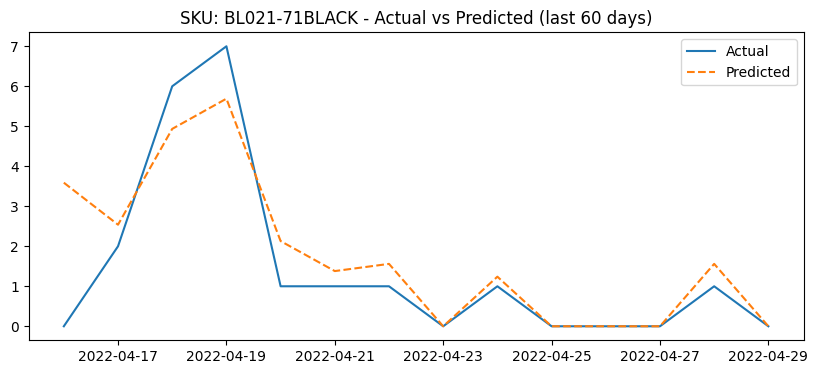

In [63]:
sku_to_plot = daily['SKU'].unique()[0]
s = daily[daily['SKU']==sku_to_plot].copy().sort_values('Date')

mask60 = s['Date'] > (s['Date'].max() - pd.Timedelta(days=60))

# Numeric features
num_X_s = s[mask60][['dayofweek', 'month', 'day', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling7_mean', 'rolling7_std']]

# One-hot encode Category using trained encoder
cat_X_s = encoder.transform(s[mask60][['Category']])
cat_X_s = pd.DataFrame(cat_X_s, columns=cat_cols, index=num_X_s.index)

# Combine
X_s = pd.concat([num_X_s, cat_X_s], axis=1).fillna(0)

# Predict
pred_s = rf.predict(X_s)

# Plot
plt.figure(figsize=(10,4))
plt.plot(s[mask60]['Date'], s[mask60]['demand'], label='Actual')
plt.plot(s[mask60]['Date'], pred_s, linestyle='--', label='Predicted')
plt.title(f"SKU: {sku_to_plot} - Actual vs Predicted (last 60 days)")
plt.legend()
plt.show()
